# Mobile Net Model Processing

First we are going to prep our images to go into the model, creating a testing subset for faster processing and then work through optimizing the model by adjusting the parameters.


In [31]:
# Import Dependencies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
import datetime

# Keras and TensorFlow imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import load_model

# KerasTuner imports
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch


In [2]:
# Read the CSV file into a DataFrame: df
df = pd.read_csv('resources/csv/dog_annotations_with_groups.csv')
df.head()

,filename,breed_name,folder,xmin,ymin,xmax,ymax,pose,truncated,difficult,group_x,group_y,group
0,n02085620_10074.jpg,chihuahua,n02085620-Chihuahua,25,10,276,498,Unspecified,0,0,Toy,Toy,Toy
1,n02085620_10131.jpg,chihuahua,n02085620-Chihuahua,49,9,393,493,Unspecified,0,0,Toy,Toy,Toy
2,n02085620_10621.jpg,chihuahua,n02085620-Chihuahua,142,43,335,250,Unspecified,0,0,Toy,Toy,Toy
3,n02085620_1073.jpg,chihuahua,n02085620-Chihuahua,0,27,312,498,Unspecified,0,0,Toy,Toy,Toy
4,n02085620_10976.jpg,chihuahua,n02085620-Chihuahua,90,104,242,452,Unspecified,0,0,Toy,Toy,Toy


# Start with image processing

Expands the bounding box by a given percentage (default: 10%) and ensures
    it stays within the bounds of the image. The bounding box coordinates (xmin, ymin, xmax, ymax)
    are adjusted with the padding, and the resulting coordinates are clipped to fit inside the image dimensions.
    
    Parameters:
    - xmin, ymin: Top-left corner of the original bounding box
    - xmax, ymax: Bottom-right corner of the original bounding box
    - img_width, img_height: Dimensions of the image
    - padding: Percentage by which to expand the bounding box (default is 10%)
    
    Returns:
    - Updated coordinates (xmin, ymin, xmax, ymax) with padding applied and clipped to image bounds.

In [3]:
# Expand crop box function with padding
def expand_bbox(xmin, ymin, xmax, ymax, img_width, img_height, padding=0.1):
    """Expand the bounding box by 10% padding and ensure it stays within the image bounds."""
    x_pad = int((xmax - xmin) * padding)
    y_pad = int((ymax - ymin) * padding)
    
    # Ensure the crop box stays within image bounds
    xmin = max(0, xmin - x_pad)
    ymin = max(0, ymin - y_pad)
    xmax = min(img_width, xmax + x_pad)
    ymax = min(img_height, ymax + y_pad)
    
    return xmin, ymin, xmax, ymax

# Main cropping loop
error_log = []
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'
image_folder = 'resources/stanford-dogs-dataset/images'
breed_issues = {}

for _, row in df.iterrows():
    breed_name = row["breed_name"]
    folder_name = row["folder"].strip()  # Strip newlines & spaces
    filename = row["filename"].strip()  # Ensure filename is not empty

    # Check if filename is empty or incorrect
    if not filename or filename == "%s.jpg":
        error_log.append(f"Invalid filename for {breed_name} in {folder_name}")
        continue  # Skip this entry

    img_path = os.path.join(image_folder, folder_name, filename)

    if not os.path.exists(img_path):
        error_log.append(img_path)
        continue  # Skip missing images

    try:
        # Open image and get its size
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Update the bounding box with padding
        xmin, ymin, xmax, ymax = expand_bbox(row["xmin"], row["ymin"], row["xmax"], row["ymax"], img_width, img_height)

        # Crop the image based on the updated bounding box
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        # Ensure breed folder exists for cropped images
        breed_cropped_path = os.path.join(cropped_folder, breed_name)
        os.makedirs(breed_cropped_path, exist_ok=True)

        # Save cropped image
        save_path = os.path.join(breed_cropped_path, filename)
        cropped_img.save(save_path)

    except Exception as e:
        error_log.append(f"{img_path} - {e}")

# Save error log
with open("missing_images_log.txt", "w") as f:
    for entry in error_log:
        f.write(f"{entry}\n")

print(f"✅ Cropping complete! {len(error_log)} issues logged.")


✅ Cropping complete! 1 issues logged.


Checking in to see how the images look after the cropping.


    Randomly selects and displays a few cropped images from a randomly chosen breed folder.
    
    Parameters:
    - cropped_folder: Path to the main folder containing breed folders with cropped images.
    - num_images: Number of images to display (default is 5).
    - img_size: Tuple representing the size to which each image will be resized for display (default is (256, 256)).


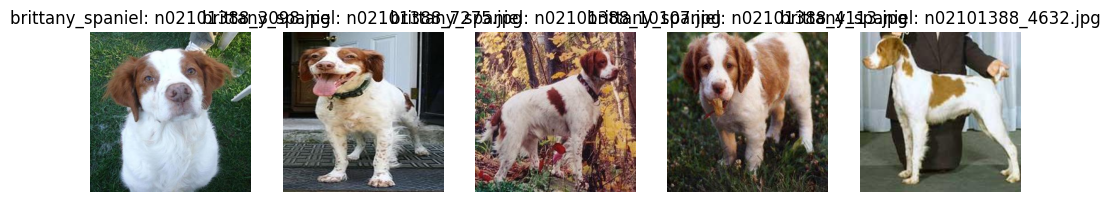

In [4]:
# Function to display a few cropped images
def check_cropped_images(cropped_folder, num_images=5, img_size=(256, 256)):
    """Randomly selects and displays cropped images."""
    breed_folders = os.listdir(cropped_folder)
    
    if not breed_folders:
        print("🚨 No breed folders found! Check your cropping process.")
        return

    breed_folder = random.choice(breed_folders)  # Pick a random breed
    breed_folder_path = os.path.join(cropped_folder, breed_folder)
    image_files = os.listdir(breed_folder_path)

    if not image_files:
        print(f"🚨 No images found in {breed_folder}! Check cropping.")
        return

    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(selected_images):
        img_path = os.path.join(breed_folder_path, image_file)
        img = Image.open(img_path)
        img = img.resize(img_size)  # Resize for display consistency

        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title(f"{breed_folder}: {image_file}")

    plt.show()

# Call function to visualize images
check_cropped_images(cropped_folder)


In [ ]:
#Another check to see if there are any missing breed folders
expected_breeds = set(df["breed_name"].unique())
actual_breeds = set(os.listdir(cropped_folder))

# Check which breeds are missing from the folders
missing_folders = expected_breeds - actual_breeds
extra_folders = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_folders)
print("📌 Extra breed folders that don't match dataset:", extra_folders)

📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()


In [ ]:
#Checking to see if there is image fallout
total_imgs = 0
for breed in os.listdir(cropped_folder):
    breed_path = os.path.join(cropped_folder, breed)
    num_images = len(os.listdir(breed_path))
    total_imgs += num_images

print(f"There are {total_imgs} cropped images")
print(f"There are {len(df['breed_name']) - total_imgs} missing images.")


There are 20579 cropped images
There are 1547 missing images.


# Image Augmentation and Splitting the Training and Validating Groups


    Resize the input image to the target size while keeping the aspect ratio.
    Adds padding to maintain the original aspect ratio if necessary.
    
    Parameters:
    - image: The input image (PIL Image or NumPy array).
    - target_size: The target size to resize the image to (default is IMG_SIZE).
    
    Returns:
    - A resized image with padding applied to meet the target size.

In [ ]:
# Set variables
IMG_SIZE = (256, 256)  # Image size
INPUT_SHAPE = (256, 256, 3)  # Image dimensions (RGB)
NUM_CLASSES = 120  # Number of dog breeds in your dataset
BATCH_SIZE = 32  # Number of images the model sees before backpropagating 

def resize_with_padding(image, target_size=IMG_SIZE):
    """Resize an image while keeping aspect ratio and adding padding."""
    image = np.array(image)  # Ensure it's a NumPy array
    
    # Convert image back to uint8 if it's in float32
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Normalize to [0, 255] and convert to uint8

    img = Image.fromarray(image)  # Convert to PIL Image
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS, centering=(0.5, 0.5)) 
    return np.array(img)  # Convert back to NumPy array



# ImageDataGenerator for Preprocessing

Through code optimization, have tried multiple changes within the ImageDataGenerator to help optimize the model and streamline results.


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Now using MobileNet's expected input format
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)

In [ ]:
# Define ImageDataGenerator with the correct preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Apply MobileNet's preprocessing
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Apply shearing transformations to images
    zoom_range=0.1,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformations
    validation_split=0.2  # Reserve 20% of the data for validation
)

    Randomly select a subset of images from the given image folder.
    
    Parameters:
    - image_folder: Path to the folder containing the images.
    - subset_size: Number of images to select (default is 3000).
    
    Returns:
    - A list of file paths to randomly selected images.

In [ ]:
# Function to get a random subset of images
def get_random_subset(image_folder, subset_size=3000):
    """Randomly select a subset of images for faster training/testing."""
    all_images = []
    for breed_folder in os.listdir(image_folder):
        breed_path = os.path.join(image_folder, breed_folder)
        if os.path.isdir(breed_path):
            all_images.extend([
                os.path.join(breed_path, img) for img in os.listdir(breed_path)
                if img.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    
    # Shuffle and select a random subset
    random.shuffle(all_images)
    subset_images = all_images[:subset_size]  # You can adjust subset_size as needed

    return subset_images

# Get random subset of images (30% of dataset)
random_subset = get_random_subset(cropped_folder, subset_size=3000)

# Create a temporary directory for the sampled images
mobile_net_sample_folder = 'resources/stanford-dogs-dataset/mobile-sample-cropped-images'
os.makedirs(mobile_net_sample_folder, exist_ok=True)

# Copy the selected images to the temporary directory
for image_path in random_subset:
    breed_folder = image_path.split(os.sep)[-2]
    breed_folder_path = os.path.join(mobile_net_sample_folder, breed_folder)
    os.makedirs(breed_folder_path, exist_ok=True)
    os.rename(image_path, os.path.join(breed_folder_path, os.path.basename(image_path)))



Found 2450 images belonging to 120 classes.
Found 550 images belonging to 120 classes.


Create our training and validating datasets based off of the randomized sample dataset that we created in the step above, double check that it includes all 120 classes.

In [18]:
# Now, use the ImageDataGenerator with the sampled subset
train_generator = datagen.flow_from_directory(
    mobile_net_sample_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    mobile_net_sample_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2450 images belonging to 120 classes.
Found 550 images belonging to 120 classes.


In [ ]:
#Another check to review all the classes detected
print(f"✅ Classes detected: {train_generator.class_indices}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


✅ Classes detected: {'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired

In [29]:
# Cross reference the CSV file that lists all breeds with the test folder to ensure all breeds are present

# Get the list of breed names from your CSV file
expected_breeds = set(df["breed_name"].unique())

# Get the actual breed folders in your cropped folder
actual_breeds = set(os.listdir(mobile_net_sample_folder))

# Check for missing and extra breeds
missing_breeds = expected_breeds - actual_breeds
extra_breeds = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_breeds)
print("📌 Extra breed folders that don't match dataset:", extra_breeds)

# Optionally, print the breeds that match
matching_breeds = expected_breeds & actual_breeds
print("📌 Matching breeds:", matching_breeds)


📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()
📌 Matching breeds: {'ibizan_hound', 'boston_bull', 'maltese_dog', 'borzoi', 'entlebucher', 'papillon', 'whippet', 'english_setter', 'labrador_retriever', 'basset', 'airedale', 'miniature_poodle', 'american_staffordshire_terrier', 'norwich_terrier', 'weimaraner', 'malinois', 'curly-coated_retriever', 'dandie_dinmont', 'norwegian_elkhound', 'chow', 'sealyham_terrier', 'brabancon_griffon', 'cocker_spaniel', 'eskimo_dog', 'greater_swiss_mountain_dog', 'sussex_spaniel', 'french_bulldog', 'staffordshire_bullterrier', 'welsh_springer_spaniel', 'malamute', 'briard', 'lakeland_terrier', 'shetland_sheepdog', 'mexican_hairless', 'rottweiler', 'affenpinscher', 'doberman', 'saluki', 'flat-coated_retriever', 'tibetan_terrier', 'bernese_mountain_dog', 'west_highland_white_terrier', 'great_pyrenees', 'giant_schnauzer', 'irish_terrier', 'basenji', 'groenendael', 'bouvier_des_flandres', 'borde

Check the images one more time after all processing and before they go into the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9968244..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9858092..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4978832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow w

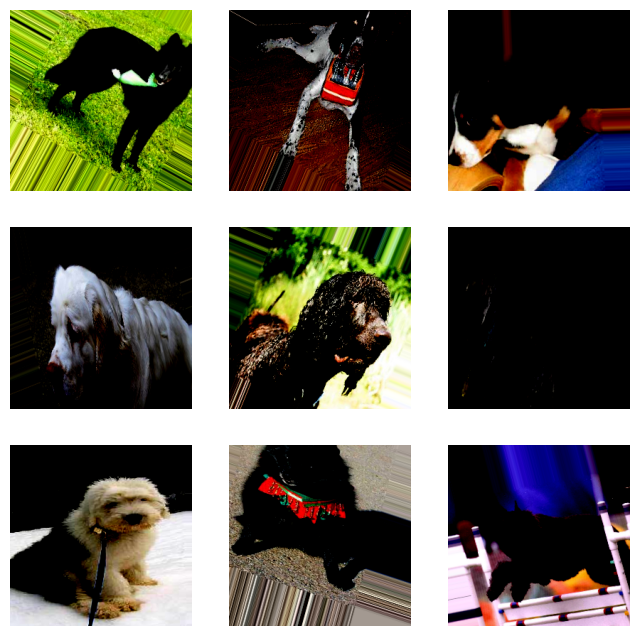

In [12]:
# Get a batch of augmented images from the train_generator
batch = next(val_generator)  # You can specify the generator name here

# Visualize 9 random images from the batch
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i])  # Images are in the first part of the batch
    ax.axis('off')
plt.show()


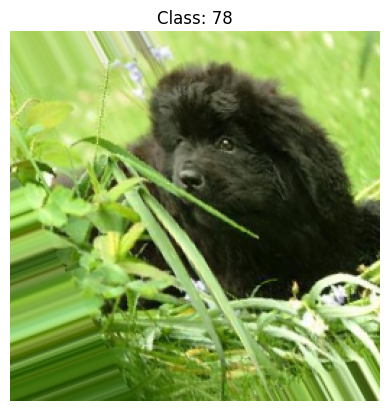

In [13]:
batch = next(train_generator)  # Get first batch
image, label = batch[0][0], batch[1][0]  # First image & label

plt.imshow((image + 1) / 2)  # Convert back to [0,1] range for viewing
plt.title(f"Class: {np.argmax(label)}")
plt.axis("off")
plt.show()


In [14]:
# Test if images are correctly preprocessed
batch_images, batch_labels = next(train_generator)
print(f"Image batch shape: {batch_images.shape}")  
print(f"Label batch shape: {batch_labels.shape}")  
print(f"Pixel range: min={batch_images.min()}, max={batch_images.max()}")  # Should be ~[-1, 1]

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 120)
Pixel range: min=-1.0, max=1.0


# Mobile Net Model Testing

Freezing the Entire Base Model:

The MobileNet base model is loaded with pre-trained weights from ImageNet (weights='imagenet'), but all layers of the base model are frozen (trainable = False).
This means that no weights in the base model will be updated during training; only the new top layers (dense layers) will learn.


Model Architecture:

Base Model: 
MobileNet without the top classification layer (useful for feature extraction).

Top Layers:
GlobalAveragePooling2D for dimensionality reduction.
A Dense layer with 1024 units and ReLU activation for learning.
A final Dense layer with NUM_CLASSES units and softmax activation for multi-class classification.

Training:

The model is trained for 10 epochs.
Uses Adam optimizer with default learning rate and categorical_crossentropy loss.
Training and validation accuracy are tracked for these epochs.
No Early Stopping or Checkpoints: No mechanism in place to stop training early or save the best model.

In [ ]:
# Load MobileNet pre-trained with ImageNet weights
mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model
mn_base_model.trainable = False

# Define the model
mn_model = Sequential([
    mn_base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),  # Dense layer for learning
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification (dog breeds)
])

# Compile the model
mn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary to check architecture
mn_model.summary()


C:\Users\kbuma\AppData\Local\Temp\ipykernel_103328\964822495.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │       123,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401,464 (16.79 MB)

 Trainable params: 1,172,600 (4.47 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [22]:
history = mn_model.fit(
    train_generator,
    epochs=10,  # Start with 10 epochs
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),  # Total number of batches per epoch
    validation_steps=len(val_generator)   # Total number of batches per validation epoch
)


c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.4514 - loss: 2.3413 - val_accuracy: 0.7154 - val_loss: 0.9220
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 499s 967ms/step - accuracy: 0.7826 - loss: 0.6924 - val_accuracy: 0.7564 - val_loss: 0.8176
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 492s 954ms/step - accuracy: 0.8257 - loss: 0.5431 - val_accuracy: 0.7549 - val_loss: 0.8093
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1358s 3s/step - accuracy: 0.8522 - loss: 0.4438 - val_accuracy: 0.7652 - val_loss: 0.7975
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - accuracy: 0.8762 - loss: 0.3728 - val_accuracy: 0.7706 - val_loss: 0.7730
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.8918 - loss: 0.3208 - val_accuracy: 0.7743 - val_loss: 0.8424
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.9012 - loss: 0.2900 - val_accuracy: 0.7650 - val_loss: 0.8862
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.9153 - loss: 0.2573 - v

In [23]:

# Check the history of validation accuracy
val_accuracy = history.history['val_accuracy']  # Get validation accuracy for each epoch

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(val_accuracy)  # Index of the best epoch

# Print out the best epoch and its validation accuracy
print(f"Best Epoch: {best_epoch + 1}, Validation Accuracy: {val_accuracy[best_epoch]}")





Best Epoch: 6, Validation Accuracy: 0.7743123769760132


In [ ]:

# Save the model at the best epoch
mn_model.save('mobile_net_model.h5')  # Save model as .h5 file
print("First model saved as 'mobile_net_model.h5'")


First model saved as 'mobile_net_model.h5'


Best Epoch, Epoch 6 at a validation accuracy of 77%, is saved off to a H5 file.  But Validation Loss is still high, lets continue to optimize to see if we can better train this model

# Mobile Net Phase 1 Optimization

Fine-Tuning the Base Model:

The MobileNet base model is also loaded with pre-trained weights from ImageNet, but here deeper layers of the model are unfrozen for fine-tuning:
The first 75 layers of MobileNet remain frozen (no updates during training).
The layers after the 75th layer are unfrozen to be trainable, allowing the model to adjust these deeper layers for the specific dataset.

Model Architecture:

Base Model: MobileNet without the top classification layer.

Top Layers:
GlobalAveragePooling2D for dimensionality reduction.
A Dense layer with 1024 units and ReLU activation.
A Dropout(0.3) layer to reduce overfitting.
A second Dense layer with 512 units and ReLU activation.
Another Dropout(0.3) layer for regularization.
A final Dense layer with NUM_CLASSES units and softmax activation for classification.

Training:

Longer Training (20 Epochs): This model is trained for 20 epochs to allow for more extensive learning.
Smaller Learning Rate: The Adam optimizer is used with a lower learning rate of 0.0001 to avoid overshooting the optimal solution, especially when fine-tuning the deeper layers.
Early Stopping: Early stopping is included to monitor the validation loss. If there is no improvement for 3 consecutive epochs (patience=3), training will stop to prevent overfitting.
Model Checkpointing: The best model is saved during training using the ModelCheckpoint callback. The model with the lowest validation loss is saved to a unique file, named with the current timestamp.

In [ ]:


# Load MobileNet pre-trained with ImageNet weights
mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Unfreeze the deeper layers for fine-tuning (adjust as needed)
for layer in mn_base_model.layers[:75]:  # Keep first 75 layers frozen
    layer.trainable = False
for layer in mn_base_model.layers[75:]:  # Fine-tune deeper layers
    layer.trainable = True

# Define the model
mn_model = Sequential([
    mn_base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)

mn_model.compile(optimizer=optimizer, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Model summary
mn_model.summary()




# 🌟 Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 🌟 Save the best model with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = ModelCheckpoint(
    f'best_mobilenet_model_{timestamp}.h5',  # Unique filename
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)



C:\Users\kbuma\AppData\Local\Temp\ipykernel_27228\3272209446.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,864,824 (18.56 MB)

 Trainable params: 3,225,208 (12.30 MB)

 Non-trainable params: 1,639,616 (6.25 MB)

In [16]:
# 🌟 Train the model
history = mn_model.fit(
    train_generator,
    epochs=20,  # Train longer for better performance
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, checkpoint]
)

c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0170 - loss: 4.9516
Epoch 1: val_loss improved from inf to 4.41277, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.0170 - loss: 4.9496 - val_accuracy: 0.0945 - val_loss: 4.4128
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.0922 - loss: 4.3475
Epoch 2: val_loss improved from 4.41277 to 3.84223, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.0923 - loss: 4.3462 - val_accuracy: 0.2127 - val_loss: 3.8422
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.1772 - loss: 3.7010
Epoch 3: val_loss improved from 3.84223 to 3.11177, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1774 - loss: 3.6993 - val_accuracy: 0.3164 - val_loss: 3.1118
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.3054 - loss: 2.9719
Epoch 4: val_loss improved from 3.11177 to 2.53240, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3054 - loss: 2.9712 - val_accuracy: 0.4109 - val_loss: 2.5324
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.3795 - loss: 2.4761
Epoch 5: val_loss improved from 2.53240 to 2.07710, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.3794 - loss: 2.4755 - val_accuracy: 0.5036 - val_loss: 2.0771
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.4488 - loss: 2.0745
Epoch 6: val_loss improved from 2.07710 to 1.82999, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4488 - loss: 2.0744 - val_accuracy: 0.5091 - val_loss: 1.8300
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.5100 - loss: 1.8449
Epoch 7: val_loss improved from 1.82999 to 1.65739, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5100 - loss: 1.8444 - val_accuracy: 0.5527 - val_loss: 1.6574
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.5477 - loss: 1.5876
Epoch 8: val_loss improved from 1.65739 to 1.56132, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5477 - loss: 1.5876 - val_accuracy: 0.5655 - val_loss: 1.5613
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.5943 - loss: 1.4758
Epoch 9: val_loss improved from 1.56132 to 1.41069, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5945 - loss: 1.4751 - val_accuracy: 0.6164 - val_loss: 1.4107
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.6485 - loss: 1.2555
Epoch 10: val_loss improved from 1.41069 to 1.37539, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6485 - loss: 1.2557 - val_accuracy: 0.6036 - val_loss: 1.3754
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6710 - loss: 1.1403
Epoch 11: val_loss improved from 1.37539 to 1.35217, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6709 - loss: 1.1410 - val_accuracy: 0.6164 - val_loss: 1.3522
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.6877 - loss: 1.0610
Epoch 12: val_loss improved from 1.35217 to 1.28914, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6877 - loss: 1.0612 - val_accuracy: 0.6400 - val_loss: 1.2891
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.7046 - loss: 1.0034
Epoch 13: val_loss improved from 1.28914 to 1.25515, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7047 - loss: 1.0035 - val_accuracy: 0.6509 - val_loss: 1.2551
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.7389 - loss: 0.9048
Epoch 14: val_loss improved from 1.25515 to 1.22952, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7389 - loss: 0.9048 - val_accuracy: 0.6364 - val_loss: 1.2295
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7586 - loss: 0.8255
Epoch 15: val_loss improved from 1.22952 to 1.22470, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7587 - loss: 0.8253 - val_accuracy: 0.6236 - val_loss: 1.2247
Epoch 16/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.7682 - loss: 0.7778
Epoch 16: val_loss improved from 1.22470 to 1.21975, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7683 - loss: 0.7777 - val_accuracy: 0.6509 - val_loss: 1.2198
Epoch 17/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7921 - loss: 0.7225
Epoch 17: val_loss did not improve from 1.21975
77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7921 - loss: 0.7227 - val_accuracy: 0.6364 - val_loss: 1.2427
Epoch 18/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.8068 - loss: 0.6380
Epoch 18: val_loss improved from 1.21975 to 1.17382, saving model to best_mobilenet_model_20250211_185835.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8067 - loss: 0.6383 - val_accuracy: 0.6582 - val_loss: 1.1738
Epoch 19/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8118 - loss: 0.6351
Epoch 19: val_loss did not improve from 1.17382
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8118 - loss: 0.6351 - val_accuracy: 0.6255 - val_loss: 1.2366
Epoch 20/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8324 - loss: 0.5832
Epoch 20: val_loss did not improve from 1.17382
77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8324 - loss: 0.5832 - val_accuracy: 0.6436 - val_loss: 1.2135
Restoring model weights from the end of the best epoch: 18.


The model training results show a steady improvement in both training accuracy and validation loss over the 20 epochs, with notable milestones:

Training Performance:

Training Accuracy: The training accuracy steadily increased from 1.7% in Epoch 1 to 83.2% by Epoch 20.

Training Loss: The training loss decreased from 4.95 in Epoch 1 to 0.58 in Epoch 20, indicating the model was successfully learning.


Validation Performance:

Validation Accuracy: The validation accuracy improved from 9.5% in Epoch 1 to 64.4% in Epoch 20.

Validation Loss: The validation loss decreased from 4.41 in Epoch 1 to 1.21 in Epoch 20, but the improvements began to slow down after Epoch 18. There were some fluctuations, as seen in epochs 17–19 where validation loss didn't improve.

Final observations:

The model shows signs of overfitting after Epoch 18, where validation accuracy fluctuates, suggesting it reached a point where it struggled to generalize better.

# Mobile Net Phase 2 Optimization

The Phase 2 Optimization model is designed to combat overfitting by introducing regularization, increased dropout, and fine-tuning of the deeper layers of MobileNet. It also uses a more sophisticated set of callbacks to manage training more effectively (such as learning rate reduction and early stopping).

Fine-tunes MobileNet by freezing the first 75 layers and allowing deeper layers (from layer 75 onward) to be trainable. This means that the deeper layers, which capture more specific features, can be adjusted during training to better fit the target task.


Includes L2 regularization in the fully connected layers (1024 and 512 neurons) to prevent overfitting. This adds a penalty term to the loss based on the magnitude of the model’s weights.


 Increased dropout to 0.4 in both fully connected layers (1024 and 512 neurons), which helps reduce overfitting by randomly setting a fraction of the input units to zero during training.

 Uses a lower learning rate of 0.0001 to allow for more gradual optimization and better convergence, particularly after fine-tuning the deeper layers of MobileNet.

Includes a combination of multiple callbacks:
Early stopping (restoring the best model weights when validation loss stops improving).
Reduce learning rate on plateau (reduces the learning rate by a factor of 10 when validation loss stops improving for 2 epochs).
ModelCheckpoint (saves the best model based on validation loss).

Has a more complex architecture with:
2 fully connected layers (1024 and 512 neurons) with L2 regularization and dropout after each layer.
The same final output layer (softmax activation) to predict the classes.

In [ ]:
# Load MobileNet pre-trained with ImageNet weights
mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Unfreeze deeper layers for fine-tuning (adjust as needed)
for layer in mn_base_model.layers[:75]:  # Keep first 75 layers frozen
    layer.trainable = False
for layer in mn_base_model.layers[75:]:  # Fine-tune deeper layers
    layer.trainable = True

# Define the model with L2 regularization and increased dropout
mn_model = Sequential([
    mn_base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)),  # Added L2
    Dropout(0.4),  # Increased dropout
    Dense(512, activation='relu', kernel_regularizer=l2(0.0005)),  # Added L2
    Dropout(0.4),  # Increased dropout
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model with initial learning rate
optimizer = Adam(learning_rate=0.0001)

mn_model.compile(optimizer=optimizer, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Model summary
mn_model.summary()

# 🌟 Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 🌟 Reduce learning rate when val_loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce LR by 10x
    patience=2,  # Wait for 2 epochs before reducing
    min_lr=1e-6,  # Don't go lower than this
    verbose=1
)

# 🌟 Save the best model with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = ModelCheckpoint(
    f'best_mobilenet_model_{timestamp}.h5',  # Unique filename
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Add reduce_lr to your callbacks list
callbacks = [early_stopping, reduce_lr, checkpoint]


C:\Users\kbuma\AppData\Local\Temp\ipykernel_27228\1180178935.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,864,824 (18.56 MB)

 Trainable params: 3,225,208 (12.30 MB)

 Non-trainable params: 1,639,616 (6.25 MB)

In [23]:
# 🌟 Train the model
history = mn_model.fit(
    train_generator,
    epochs=35,  # Extended for better fine-tuning
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr, checkpoint],  # Added reduce_lr
    shuffle=True  # Ensure data is shuffled for better training
)


Epoch 1/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0114 - loss: 5.9154
Epoch 1: val_loss improved from inf to 5.30867, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.0115 - loss: 5.9133 - val_accuracy: 0.0764 - val_loss: 5.3087 - learning_rate: 1.0000e-04
Epoch 2/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0568 - loss: 5.3129
Epoch 2: val_loss improved from 5.30867 to 4.79825, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.0570 - loss: 5.3117 - val_accuracy: 0.2036 - val_loss: 4.7983 - learning_rate: 1.0000e-04
Epoch 3/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1265 - loss: 4.8436
Epoch 3: val_loss improved from 4.79825 to 4.20918, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.1267 - loss: 4.8421 - val_accuracy: 0.2945 - val_loss: 4.2092 - learning_rate: 1.0000e-04
Epoch 4/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2077 - loss: 4.2832
Epoch 4: val_loss improved from 4.20918 to 3.57203, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2080 - loss: 4.2813 - val_accuracy: 0.4200 - val_loss: 3.5720 - learning_rate: 1.0000e-04
Epoch 5/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2986 - loss: 3.6959
Epoch 5: val_loss improved from 3.57203 to 3.16789, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.2987 - loss: 3.6953 - val_accuracy: 0.4945 - val_loss: 3.1679 - learning_rate: 1.0000e-04
Epoch 6/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3615 - loss: 3.3436
Epoch 6: val_loss improved from 3.16789 to 2.78071, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3616 - loss: 3.3427 - val_accuracy: 0.5436 - val_loss: 2.7807 - learning_rate: 1.0000e-04
Epoch 7/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4246 - loss: 2.9881
Epoch 7: val_loss improved from 2.78071 to 2.55872, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4247 - loss: 2.9877 - val_accuracy: 0.5945 - val_loss: 2.5587 - learning_rate: 1.0000e-04
Epoch 8/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5075 - loss: 2.7284
Epoch 8: val_loss improved from 2.55872 to 2.39452, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5075 - loss: 2.7280 - val_accuracy: 0.6200 - val_loss: 2.3945 - learning_rate: 1.0000e-04
Epoch 9/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5418 - loss: 2.5172
Epoch 9: val_loss improved from 2.39452 to 2.26962, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5419 - loss: 2.5170 - val_accuracy: 0.6236 - val_loss: 2.2696 - learning_rate: 1.0000e-04
Epoch 10/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5762 - loss: 2.3018
Epoch 10: val_loss improved from 2.26962 to 2.13683, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5762 - loss: 2.3022 - val_accuracy: 0.6564 - val_loss: 2.1368 - learning_rate: 1.0000e-04
Epoch 11/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5947 - loss: 2.2219
Epoch 11: val_loss improved from 2.13683 to 2.06664, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5947 - loss: 2.2218 - val_accuracy: 0.6636 - val_loss: 2.0666 - learning_rate: 1.0000e-04
Epoch 12/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6432 - loss: 2.1013
Epoch 12: val_loss improved from 2.06664 to 2.04540, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6432 - loss: 2.1012 - val_accuracy: 0.6491 - val_loss: 2.0454 - learning_rate: 1.0000e-04
Epoch 13/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6729 - loss: 1.9548
Epoch 13: val_loss improved from 2.04540 to 1.96128, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6730 - loss: 1.9545 - val_accuracy: 0.6782 - val_loss: 1.9613 - learning_rate: 1.0000e-04
Epoch 14/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6964 - loss: 1.8909
Epoch 14: val_loss improved from 1.96128 to 1.91086, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6964 - loss: 1.8907 - val_accuracy: 0.6927 - val_loss: 1.9109 - learning_rate: 1.0000e-04
Epoch 15/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7161 - loss: 1.7916
Epoch 15: val_loss improved from 1.91086 to 1.89925, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7161 - loss: 1.7916 - val_accuracy: 0.6855 - val_loss: 1.8992 - learning_rate: 1.0000e-04
Epoch 16/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7538 - loss: 1.6625
Epoch 16: val_loss did not improve from 1.89925
77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7537 - loss: 1.6627 - val_accuracy: 0.6945 - val_loss: 1.9097 - learning_rate: 1.0000e-04
Epoch 17/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7681 - loss: 1.6219
Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 17: val_loss did not improve from 1.89925
77/77 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7681 - loss: 1.6216 - val_accuracy: 0.6782 - val_loss: 1.9418 - learning_rate: 1.0000e-04
Epoch 18/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7919 - loss: 1.5607
Epoch 18: val_loss improved from 1.89925 to 1.84360, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7919 - loss: 1.5607 - val_accuracy: 0.7018 - val_loss: 1.8436 - learning_rate: 1.0000e-05
Epoch 19/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7883 - loss: 1.4968
Epoch 19: val_loss improved from 1.84360 to 1.84034, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7883 - loss: 1.4968 - val_accuracy: 0.7109 - val_loss: 1.8403 - learning_rate: 1.0000e-05
Epoch 20/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8078 - loss: 1.4594
Epoch 20: val_loss improved from 1.84034 to 1.79395, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8076 - loss: 1.4597 - val_accuracy: 0.7145 - val_loss: 1.7940 - learning_rate: 1.0000e-05
Epoch 21/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7862 - loss: 1.5281
Epoch 21: val_loss did not improve from 1.79395
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7862 - loss: 1.5280 - val_accuracy: 0.7018 - val_loss: 1.8328 - learning_rate: 1.0000e-05
Epoch 22/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7998 - loss: 1.4993
Epoch 22: val_loss improved from 1.79395 to 1.78283, saving model to best_mobilenet_model_20250211_192745.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7997 - loss: 1.4995 - val_accuracy: 0.7145 - val_loss: 1.7828 - learning_rate: 1.0000e-05
Epoch 23/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8079 - loss: 1.4932
Epoch 23: val_loss did not improve from 1.78283
77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8079 - loss: 1.4931 - val_accuracy: 0.7182 - val_loss: 1.8028 - learning_rate: 1.0000e-05
Epoch 24/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7883 - loss: 1.4811
Epoch 24: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 24: val_loss did not improve from 1.78283
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7884 - loss: 1.4810 - val_accuracy: 0.7145 - val_loss: 1.8337 - learning_rate: 1.0000e-05
Epoch 25/35
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8246 - loss: 1.4204
Epoch 25: val_loss did not improve from 1.78283
77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8245 - loss: 1.4207 - val_accuracy: 0.6982 - val_loss: 1

In [34]:
# Load the best model saved during training
best_model = load_model(f'best_mobilenet_model_{timestamp}.h5')

# Recompile the model to restore compiled metrics
optimizer = Adam(learning_rate=0.0001)  # Use the same optimizer as before
best_model.compile(optimizer=optimizer, 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

# Display the full model summary
best_model.summary()

# Now, evaluate the model on the validation set (or test set if applicable)
val_loss, val_accuracy = best_model.evaluate(val_generator)

# Print the evaluation result
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,864,824 (18.56 MB)

 Trainable params: 3,225,208 (12.30 MB)

 Non-trainable params: 1,639,616 (6.25 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 880ms/step - accuracy: 0.7103 - loss: 1.7751
Validation Loss: 1.869630217552185
Validation Accuracy: 0.696363627910614


Training Results:

Accuracy: 71.03% on the final epoch

Loss: 1.7751 on the final epoch

Validation Loss: 1.8696

Validation Accuracy: 69.64%

This means your model performs fairly well, with an accuracy of about 71% on the training data and 69.64% on the validation data. model is performing well on the training data but less so on the validation data. The training loss is lower (1.7751) compared to the validation loss (1.8696), indicating that the model is overfitting. Overfitting happens when the model learns the training data too well, including noise or irrelevant patterns, and doesn't generalize well to new, unseen data.

In [ ]:
#Let's check the model performance on the test images, this may be bias because these could have been seen in the model before.  More testing will happen in the future.

# Path to the directory containing your test images
test_image_dir = 'resources/stanford-dogs-dataset/mobile-sample-cropped-images'

# Create an ImageDataGenerator to preprocess images (normalization, resizing)
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the pixel values to [0, 1]

# Load the images from the directory and resize them
test_generator = test_datagen.flow_from_directory(
    test_image_dir,
    target_size=(IMG_SIZE[0], IMG_SIZE[1]),  # Match the input size expected by MobileNet
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Include labels for comparison
    shuffle=False  # We want to predict on each image in order
)

# Now, you can use `test_generator` to predict on your images
predictions = mn_model.predict(test_generator)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get confidence levels (probabilities)
confidence_levels = np.max(predictions, axis=1)

# Get the true labels from the generator
true_classes = test_generator.classes  # The correct labels
class_labels = test_generator.class_indices  # Mapping of class indices to class labels

# Example: Print the predicted class, confidence, and true class for each test image
for i in range(len(predicted_classes)):
    true_class = true_classes[i]  # The correct class index
    true_class_label = list(class_labels.keys())[list(class_labels.values()).index(true_class)]  # Map index to label
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_classes[i])]  # Map predicted index to label
    
    print(f"Image {i+1}: Predicted Class = {predicted_class_label}, Confidence = {confidence_levels[i]:.4f}, True Class = {true_class_label}")


Found 3000 images belonging to 120 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 727ms/step
Image 1: Predicted Class = affenpinscher, Confidence = 0.9128, True Class = affenpinscher
Image 2: Predicted Class = affenpinscher, Confidence = 0.5043, True Class = affenpinscher
Image 3: Predicted Class = affenpinscher, Confidence = 0.9946, True Class = affenpinscher
Image 4: Predicted Class = affenpinscher, Confidence = 0.9592, True Class = affenpinscher
Image 5: Predicted Class = norfolk_terrier, Confidence = 0.2481, True Class = affenpinscher
Image 6: Predicted Class = yorkshire_terrier, Confidence = 0.3158, True Class = affenpinscher
Image 7: Predicted Class = affenpinscher, Confidence = 0.9893, True Class = affenpinscher
Image 8: Predicted Class = affenpinscher, Confidence = 0.9796, True Class = affenpinscher
Image 9: Predicted Class = affenpinscher, Confidence = 0.8984, True Class = affenpinscher
Image 10: Predicted Class = affenpinscher, Confidence = 0.9335, True Class = affenpinscher
Image 1